<a href="https://colab.research.google.com/github/mohamed32145/MindCare/blob/main/fslDataproccessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

"""
 ADNI1 MRI Image Preprocessing Overview

The ADNI1 MRI images undergo several preprocessing steps before being made publicly available.
 This documentation outlines additional steps applied during our project for organizing and preparing these images for analysis.

---

 Image Folder Naming Convention & Preprocessing Status

ADNI folders named:

* `MPR-R__GradWarp__B1_Correction__N3__Scaled`
* `MPR__GradWarp__B1_Correction__N3__Scaled`

indicate that the following preprocessing has already been performed by ADNI:

GradWarp**: Corrects for gradient non-linearity (geometric distortion).
B1 Correction**: Corrects for B1 field inhomogeneity (ensures uniform intensity).
N3 Bias Field Correction**: Removes low-frequency intensity non-uniformities.
Scaling**: Normalizes image intensity across different scans.

---

 Project-Specific Preprocessing Steps

 For **AD** and **CN** groups:

Select only images from folders:

* `MPR-R__GradWarp__B1_Correction__N3__Scaled` or
* `MPR__GradWarp__B1_Correction__N3__Scaled`

Perform the following preprocessing steps:

1.  Skull Stripping

   * Tool: [FSL BET](https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/BET)

2. Resampling to Common Voxel Size (e.g., 1×1×1 mm³)

   * Tool: [`nibabel`](https://nipy.org/nibabel/) + `scipy.ndimage`

3. Reshaping to Consistent Dimensions

   * Shape: `128 × 128 × 128`

---

 For pMCI and sMCI groups:

If the folder name contains:

* `MPR-R__GradWarp__B1_Correction__N3__Scaled` or
* `MPR__GradWarp__B1_Correction__N3__Scaled`

Apply **the same preprocessing steps as AD/CN**.

 If the folder name is:

* `MPR__GradWarp__N3__Scaled` (i.e., missing B1 Correction)

Apply the following steps:

1. N4 Bias Field Correction

   * Tool: [ANTs N4BiasFieldCorrection](https://github.com/ANTsX/ANTs) or [SimpleITK](https://simpleitk.readthedocs.io/)

2. Then apply all AD/CN preprocessing steps:

   * Skull stripping (FSL BET)
   * Resampling
   * Reshaping

---

 Tools Used

| Task                     | Tool/Library     |
| ------------------------ | ---------------- |
| Skull Stripping          | FSL BET          |
| Bias Field Correction    | SimpleITK / ANTs |
| Resampling               | nibabel, scipy   |
| Reshaping to uniform dim | numpy            |

"""


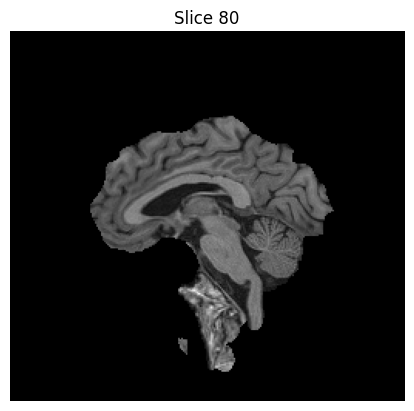

In [ ]:
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np

# Load image
img = nib.load("image_brain.nii.gz")
data = img.get_fdata()

# Show middle slice
slice_index = data.shape[2] // 2
plt.imshow(data[:, :, slice_index], cmap="gray")
plt.title(f"Slice {slice_index}")
plt.axis("off")
plt.show()

In [ ]:
df.groupby('Group').nunique()

,Image Data ID,Subject,Sex,Age,Visit,Modality,Description,Type,Acq Date,Format,Downloaded
Group,,,,,,,,,,,
AD,453,99,2,36,4,1,11,1,315,1,0
CN,748,135,2,34,6,1,12,1,495,1,0
MCI,981,148,2,37,6,1,12,1,596,1,0


In [ ]:
import os
import nibabel as nib
import numpy as np
import SimpleITK as sitk
from scipy.ndimage import zoom
from subprocess import run
from pathlib import Path
import shutil

# Set common voxel size and output shape
TARGET_VOXEL_SIZE = (1.0, 1.0, 1.0)
TARGET_SHAPE = (128, 128, 128)

# Paths to data directories
root_dirs = {
    "AD": r"C:\ADNI\AD",
    "CN": r"C:\ADNI\CN",
    "pMCI": r"C:\ADNI\pMCI",
    "sMCI": r"C:\ADNI\sMCI"
}

# Output root
output_root = r"C:\ADNI_Preprocessed"

def skull_strip_fsl(input_path, output_path):
    run(["bet", input_path, output_path, "-R", "-f", "0.5", "-g", "0"])

def resample_image(image, target_voxel_size):
    current_affine = image.affine
    current_header = image.header
    current_voxel_size = current_header.get_zooms()[:3]
    zoom_factors = [c / t for c, t in zip(current_voxel_size, target_voxel_size)]
    resampled_data = zoom(image.get_fdata(), zoom_factors, order=1)
    new_affine = np.copy(current_affine)
    for i in range(3):
        new_affine[i, i] *= target_voxel_size[i] / current_voxel_size[i]
    return nib.Nifti1Image(resampled_data, new_affine)

def reshape_to_target(image, target_shape):
    data = image.get_fdata()
    pad_width = [(0, max(0, target - s)) for s, target in zip(data.shape, target_shape)]
    padded = np.pad(data, pad_width, mode='constant', constant_values=0)
    cropped = padded[:target_shape[0], :target_shape[1], :target_shape[2]]
    return nib.Nifti1Image(cropped, image.affine)

def n4_bias_correction(input_image):
    sitk_image = sitk.GetImageFromArray(input_image.get_fdata())
    sitk_image = sitk.Cast(sitk_image, sitk.sitkFloat32)
    mask_image = sitk.OtsuThreshold(sitk_image, 0, 1, 200)
    corrector = sitk.N4BiasFieldCorrectionImageFilter()
    corrected_image = corrector.Execute(sitk_image, mask_image)
    corrected_array = sitk.GetArrayFromImage(corrected_image)
    return nib.Nifti1Image(corrected_array, input_image.affine)

def process_image(input_path, group, out_path):
    base = os.path.basename(input_path).replace(".nii", "")
    skull_stripped_path = out_path / f"{base}_skullstripped.nii"

    # 1. Skull stripping
    skull_strip_fsl(input_path, skull_stripped_path)

    # 2. Load image
    image = nib.load(skull_stripped_path)

    # 3. Optional bias correction for pMCI/sMCI with N3 only
    if group in ["pMCI", "sMCI"] and "N3__Scaled" in input_path and "B1_Correction" not in input_path:
        image = n4_bias_correction(image)

    # 4. Resample
    image = resample_image(image, TARGET_VOXEL_SIZE)

    # 5. Reshape
    image = reshape_to_target(image, TARGET_SHAPE)

    # 6. Save final image
    final_output = out_path / f"{base}_preprocessed.nii"
    nib.save(image, final_output)
    print(f" Processed: {input_path} ➜ {final_output}")

def main():
    for group, root_dir in root_dirs.items():
        for dirpath, _, filenames in os.walk(root_dir):
            for filename in filenames:
                if filename.endswith(".nii"):
                    if group in ["AD", "CN"]:
                        if "MPR__GradWarp__B1_Correction__N3__Scaled" in dirpath or "MPR-R__GradWarp__B1_Correction__N3__Scaled" in dirpath:
                            input_path = os.path.join(dirpath, filename)
                        else:
                            continue
                    elif group in ["pMCI", "sMCI"]:
                        if ("MPR__GradWarp__N3__Scaled" in dirpath or
                            "MPR__GradWarp__B1_Correction__N3__Scaled" in dirpath or
                            "MPR-R__GradWarp__B1_Correction__N3__Scaled" in dirpath):
                            input_path = os.path.join(dirpath, filename)
                        else:
                            continue
                    else:
                        continue

                    # Define output path
                    rel_path = Path(input_path).relative_to(root_dir)
                    out_path = Path(output_root) / group / rel_path.parent
                    out_path.mkdir(parents=True, exist_ok=True)

                    # Process image
                    process_image(input_path, group, out_path)




Exists? False


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\moham\\OneDrive\\Desktop\\study\\now\\master\\data_science_lab\\adni'